In [51]:
import cv2
import numpy as np
import dlib
from imutils import resize, face_utils
import imutils
import os
import matplotlib.pyplot as plt

In [52]:
p = "data/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

img_mask = cv2.imread(os.getcwd() + "\images\mask.png")

# Facial landmarks
------------------------------


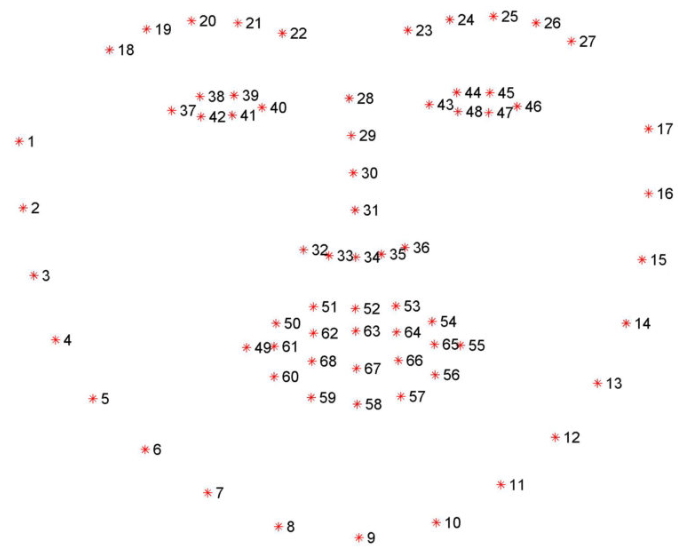

In [201]:
def make_mask(img):
    mMask = img.copy()
    mMask = cv2.cvtColor(mMask, cv2.COLOR_BGR2GRAY)
    mMask = cv2.threshold(mMask, 0, 255, cv2.THRESH_BINARY)[1]
#     mMask = imutils.rotate_bound(mMask, rotation_angle)
#     mMask = cv2.resize(mMask, img_width, )
    
    return mMask

In [202]:
def alpha_blend(foreground, background, alpha):
    fg = foreground.astype("float")
    bg = background.astype("float")
    alpha = alpha.astype("float") / 255
    
    # alpha blending
    fg = cv2.multiply(alpha, fg)
    bg = cv2.multiply(1 - alpha, bg)
    
    # add foreground + background
    output = cv2.add(fg, bg)
    
    return output.astype("uint8")

In [203]:
def overlay_image(background, foreground, coords, angle):
    (sH, sW) = foreground.shape[:2]
    (x, y) = coords
    
    halfX = int(sW/2)
    halfY = int(sH/2)
    
#     print(foreground.shape)
#     print(sH, sW)
    
    foreground = cv2.resize(foreground, (halfX*2, halfY*2), interpolation=cv2.INTER_NEAREST)
    foregroundMask = make_mask(foreground)
    
    overlay = np.zeros(background.shape, dtype="uint8")
    overlay[y-halfY :y + halfY, x-halfX:x + halfX] = foreground
    
#     print(overlay.shape)

    alpha = np.zeros(background.shape[:2], dtype="uint8")
    alpha[y-halfY :y + halfY, x-halfX:x + halfX] = foregroundMask
    alpha = np.dstack([alpha] * 3)
    
    # alpha blending to merge the foreground, background and alpha channel together
    output = alpha_blend(overlay, background, alpha)
    
    return output

In [204]:
def add_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        face_left = shape[1]
        face_right = shape[15]
        face_top = shape[28]
        face_down = shape[8]
        
        dX = face_right[0] - face_left[0]
        dY = face_right[1] - face_left[1]
        angle = np.degrees(np.arctan2(dY, dX))
        
        centerX = int((face_right[0] + face_left[0])/2)
        centerY = int((face_top[1] + face_down[1])/2)
        
#         print(angle)
        
        mask = imutils.rotate_bound(img_mask, angle)
        maskW = int((face_right[0] - face_left[0]) * 1.1)
        
        mask = imutils.resize(mask, width=maskW)

#         img = cv2.circle(img, (face_left[0], face_left[1]), 5, (255, 255, 255), -1)
#         img = cv2.circle(img, (face_right[0], face_right[1]), 5, (255, 255, 255), -1)
#         img = cv2.circle(img, (face_down[0],  face_down[1]), 5, (255, 255, 255), -1)
        
        shiftX = mask.shape[1]
        shiftY = mask.shape[0]
        y = max(0, face_down[1] - face_top[1])
        
        output = overlay_image(img, mask, (centerX, centerY), angle)
    return output
        

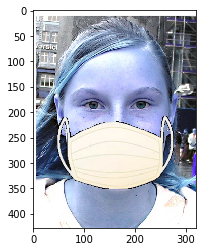

In [205]:
PATH = os.getcwd() + "\\images\\without_mask"

for img in os.listdir(PATH)[3:]:
    img_array = cv2.imread(os.path.join(PATH, img), 1)
#     img_array = cv2.resize(img_array)
    img_array = add_mask(img_array)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

In [207]:
# save modified images

WRITE_PATH = os.getcwd() + "\\images\\with_mask"

for i, img in enumerate(os.listdir(PATH)):
    try:
        img_array = cv2.imread(os.path.join(PATH, img), 1)
        img_array = add_mask(img_array)
        cv2.imwrite(os.path.join(WRITE_PATH, f"{i}.jpg"), img_array)
    except: pass